<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/kep.png" height=75 width=75>
*This notebook uses routines from [PyKE](http://github.com/keplerGO/PyKE/) which is documented [here](http://pyke.keplerscience.org/). You can find these notebooks on [GitHub](https://github.com/christinahedges/k2torials)*

<!--NAVIGATION-->
< [Querying NExSci](01.02-Querying-NEXSci.ipynb) | [Contents](index.ipynb) | [What are Light Curve Files?](01.04-Investigating-LC-Files.ipynb) >

# Folding a Light Curve

Now that we can open a light curve file and plot a light curve, we are able to see the planet transit. In the file we opened in the last notebook the transit is large and clear. We should easily be able to find a period that would be useful to fold on. Let's redraw the light curve using PyKE.

Found the following flux columns: SAP_FLUX, SAP_FLUX_ERR, PDCSAP_FLUX, PDCSAP_FLUX_ERR
Using data column PDCSAP_FLUX on the plot...
Writing output file data/kplr006922244-2010078095331_llc-kepdraw.png...


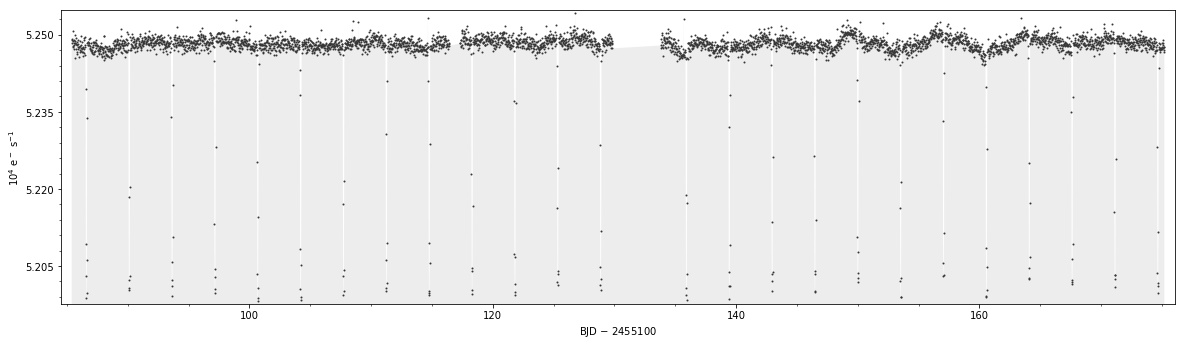

In [11]:
%matplotlib inline
from pyke import kepdraw
kepdraw('data/kplr006922244-2010078095331_llc.fits')

We'll go through finding the period and folding the light curve with two different approaches, firstly using python, and secondly using the command line.

## Python

Because the transit is so obvious and above the noise we are able to use a a simple period finding algorithm to find the transit period. We'll use *gatspy* to find the period. We'll use some bounds so that the period finding algorithm doesn't find spurious signals. The period for this planet should be between $\approx$0.2-10 days.

First off we'll import the data 

In [24]:
from astropy.io import fits
import numpy as np
h = fits.open('data/kplr006922244-2010078095331_llc.fits')
t,flux=h[1].data['TIME'],h[1].data['PDCSAP_FLUX']
#Remove NaN values
t,flux=t[np.isfinite(flux)],flux[np.isfinite(flux)]

And then use *gatspy* to find the best period

In [25]:
from gatspy import periodic
model = periodic.LombScargleFast(fit_period=True)
model.optimizer.quiet=True
model.optimizer.period_range = (0.2, 10)
model.fit(t, flux, flux.max()-flux.min())
per=model.best_period
print('Best Period: ',per)

Best Period:  1.76116955512


And finally we will fold the light curve. This can be done by simply taking the modulus of the time of each observation with the period we've found. 

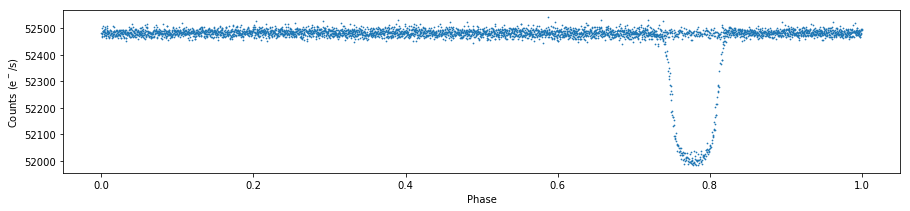

In [27]:
phase = t / per % 1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

While this has folded to a harmonic of the correct period, this is actually half the period of the planet. Often algorithms will find a period that is half that of the true period, particularly due to deep secondary eclipses. We can rectify this by doubling the period

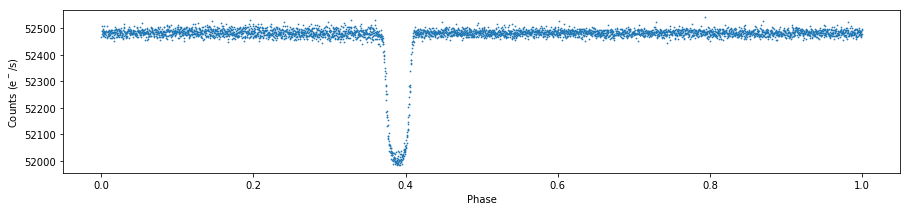

In [77]:
phase = t / (per*2) % 1

plt.figure(figsize=(15,3))
plt.scatter(phase,flux,s=0.5)
plt.xlabel('Phase')
plt.ylabel('Counts (e$^-$/s)')

## Bash/Command Line

Now we will use command line to do the same with PyKE. This time rather than using *gatspy* to create a quick period we will use a full BLS algorithm to find the period. This will be explained in more detail in a further notebook. We've set the minimum period and the maximum period to small values to save on time.

In [6]:
%%bash
kepflatten data/kplr006922244-2010078095331_llc.fits --overwrite

Writing output file data/kplr006922244-2010078095331_llc-kepflatten.fits...


100%|██████████| 180/180 [00:03<00:00, 49.43it/s]


In [7]:
%%bash
kepbls data/kplr006922244-2010078095331_llc-kepflatten.fits --minper 2 --maxper 4

 


Writing output file data/kplr006922244-2010078095331_llc-kepflatten-kepbls.fits...
      Best trial period = 3.522071123123169 days
    Time of mid-transit = BJD 2455186.6136336215
       Transit duration = 0.7337648421525955 hours
 Maximum signal residue = 0.0002483383798170339 



  0%|          | 0/1001 [00:00<?, ?it/s]/Users/ch/K2/repos/PyKE/pyke/kepbls.py:212: RuntimeWarning: Mean of empty slice
  work4[i] = np.nanmean(phsort[elements, 1])
/Users/ch/K2/repos/PyKE/pyke/kepbls.py:214: RuntimeWarning: invalid value encountered in double_scalars
  / len(elements)))
100%|██████████| 1001/1001 [06:56<00:00,  2.40it/s]


In [17]:
%%bash
kepfold data/kplr006922244-2010078095331_llc-kepflatten-kepbls.fits --overwrite --non-interactive

Writing output file data/kplr006922244-2010078095331_llc-kepflatten-kepbls-kepfold.fits...


100%|██████████| 4108/4108 [00:00<00:00, 103343.17it/s]


In [18]:
%%bash
kepdraw data/kplr006922244-2010078095331_llc-kepflatten.fits

Found the following flux columns: SAP_FLUX, SAP_FLUX_ERR, PDCSAP_FLUX, PDCSAP_FLUX_ERR, DETSAP_FLUX, DETSAP_FLUX_ERR
Using data column DETSAP_FLUX on the plot...
Writing output file data/kplr006922244-2010078095331_llc-kepflatten-kepdraw.png...


*kepfold* has produced the following image.
# I'm not sure why kepfold is doubling the data. This should be fixed in PyKE.

![alt](data/kplr006922244-2010078095331_llc-kepflatten-kepbls-kepfold.png)

# kepflatten seems to be working very well
I'm not sure if I should trust that rather tempting sinusoid

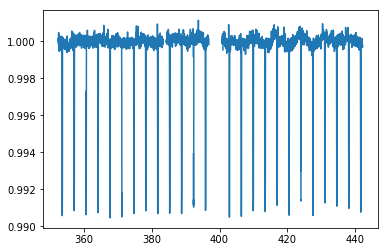

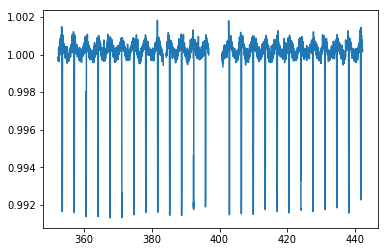

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from astropy.io import fits
h = fits.open('data/kplr006922244-2010078095331_llc-kepflatten.fits')
plt.figure()
plt.plot(h[1].data['TIME'],h[1].data['PDCSAP_FLUX']/np.nanmedian(h[1].data['PDCSAP_FLUX']))
plt.figure()
plt.plot(h[1].data['TIME'],h[1].data['DETSAP_FLUX'])

<!--NAVIGATION-->
< [Querying NExSci](01.02-Querying-NEXSci.ipynb) | [Contents](index.ipynb) | [What are Light Curve Files?](01.04-Investigating-LC-Files.ipynb) >